# Similarity explanations for ImageNet

In this notebook, we apply the similarity explanation method to a ResNet model pre-trained on the ImageNet dataset. 
We use a subset of the ImageNet dataset including 1000 random samples as training set for the explainer. The training set is constructed by picking 100 random images for each of the following classes:

* 'stingray'

* 'trilobite'

* 'centipede'

* 'slug'

* 'snail'

* 'Rhodesian ridgeback'

* 'beagle'

* 'golden retriever'

* 'sea lion'

* 'espresso' 

The test set contains 50 random samples, 5 for each of the classes above. The data set is stored in a public google storage bucket and can be fetched using the utility function `fetch_imagenet_10`. 

Given an input image of interest picked from the test set, the similarity explanation method used here aims to find images in the training set that are similar to the image of interest according to "how the model sees them", meaning that the similarity metric makes use of the gradients of the model's loss function with respect to the model's parameters. 

The similarity explanation tool supports both `pytorch` and `tensorflow` backends. In this example, we will use the `tensorflow` backend. Running this notebook on CPU can be very slow, so GPU is recommended.

A more detailed description of the method can be found [here](../methods/Similarity.ipynb). The implementation follows  [Charpiat et al., 2019](https://papers.nips.cc/paper/2019/hash/c61f571dbd2fb949d3fe5ae1608dd48b-Abstract.html) and  [Hanawa et al. 2021](https://arxiv.org/abs/2006.04528).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from alibi.datasets import fetch_imagenet_10
from alibi.explainers import GradientSimilarity

## Utils

In [3]:
def plot_similar(ds, expls, int_to_str, mean_channels, figsize=(20, 20)):
    """Plots original instances and similar instances.
    
    Parameters
    ----------
    ds 
        List of dictionaries containing instances to plot, labels and predictions.
    expls
        Similarity explainer explanation object.
    int_to_str
        Dictionary mapping label's number to label's names.
    mean_channels
        Mean channels to add to the images for visualization.
    figsize
        Figure size.
    
    Returns
    ------
    None
    """
    fig, axes = plt.subplots(5, 6, figsize=figsize, sharex=False)
    for j in range(len(ds)):
        d = ds[j]
        axes[j, 0].imshow(BGR_to_RGB(d['x']))
        label_orig = int_to_str[d['y']].split(',')[0]
        if len(label_orig) > 16:
            label_orig = label_orig[:13] + '...'
        pred_orig = int_to_str[d['pred']].split(',')[0]
        if len(pred_orig) > 16:
            pred_orig = pred_orig[:13] + '...'
        if j == 0:
            title_orig = "Original instance"
            axes[j, 0].set_title(f"{title_orig} \n" + 
                                 f"{len(title_orig) * '='} \n" + 
                                 f"Label: {label_orig} \n" + 
                                 f"Prediction: {pred_orig} ")
            
        else:
            axes[j, 0].set_title(f"Label: {label_orig} \n" +
                                 f"Prediction: {pred_orig} ")
        axes[j, 0].axis('off')
        for i in range(expls.data['most_similar'].shape[0]):
            label_sim = int_to_str[d['y_sim'][i]].split(',')[0]
            if len(label_sim) > 16:
                label_sim = label_sim[:13] + '...'
            pred_sim = int_to_str[d['preds_sim'][i]].split(',')[0]
            if len(pred_sim) > 16:
                pred_sim = pred_sim[:13] + '...'
            most_similar = BGR_to_RGB((expls.data['most_similar'][j] + mean_channels).astype(int)[i])
            
            axes[j, i + 1].imshow(most_similar, cmap='gray')
            if j == 0:
                title_most_sim = f"{i+1}{append_int(i+1)} most similar instance"
                axes[j, i + 1].set_title(f"{title_most_sim} \n" + 
                                         f"{len(title_most_sim) * '='} \n"+ 
                                         f"Label: {label_sim} \n" + 
                                         f"Prediction: {pred_sim}")
            else:
                axes[j, i + 1].set_title(f"Label: {label_sim} \n" + 
                                         f"Prediction: {pred_sim}")
            axes[j, i + 1].axis('off')

    plt.show()


def plot_distributions(ds, expls, int_to_str, figsize=(20, 20)):
    """Plots original instances and scores distributions per class.
    
    Parameters
    ----------
    ds 
        List of dictionaries containing instances to plot, labels and predictions.
    expls
        Similarity explainer explanation object.
    int_to_str
        Dictionary mapping label's number to label's names.
    figsize
        Figure size.
    
    Returns
    ------
    None
    """

    fig, axes = plt.subplots(5, 2, figsize=figsize, sharex=False)

    for i in range(len(ds)):
        d = ds[i]

        y_sim = d['y_sim']
        preds_sim = d['preds_sim']
        y = d['y']
        pred = d['pred']
        df_ditribution = pd.DataFrame({'y_sim': y_sim, 
                                       'preds_sim': preds_sim, 
                                       'scores': expls.data['scores'][i]})

        axes[i, 0].imshow(BGR_to_RGB(d['x']))
        if i == 0:
            title_orig = "Original instance"
            axes[i, 0].set_title(f"{title_orig} \n " + 
                                 f"{len(title_orig) * '='} \n" + 
                                 f"Label: {d['y']} - {int_to_str[d['y']]}  \n" + 
                                 f"Prediction: {d['pred']} - {int_to_str[d['pred']].split(',')[0]} ")
        else:
            axes[i, 0].set_title(f"Label: {d['y']} - {int_to_str[d['y']].split(',')[0]}  \n" + 
                                 f"Prediction: {d['pred']} - {int_to_str[d['pred']].split(',')[0]} ")
        axes[i, 0].axis('off')    
        df_y = df_ditribution.groupby('y_sim')['scores'].mean()
        df_y.index = [int_to_str[i] for i in df_y.index]
        df_y.sort_values(ascending=True).plot(kind='barh', ax=axes[i, 1])
        if i == 0:
            title_true_class = "Averaged scores for each true class in reference set"
            axes[i, 1].set_title(f"{title_true_class} \n" + 
                                 f"{len(title_true_class) * '='} \n ")

    fig.tight_layout()
    plt.show()

def append_int(num):
    """Converts an integer into an ordinal (ex. 1 -> 1st, 2 -> 2nd, etc.).
    
    Parameters
    ----------
    num
        Integer number.
    
    Returns
    -------
    Ordinal suffixes.
    """
    if num > 9:
        secondToLastDigit = str(num)[-2]
        if secondToLastDigit == '1':
            return 'th'
    lastDigit = num % 10
    if (lastDigit == 1):
        return 'st'
    elif (lastDigit == 2):
        return 'nd'
    elif (lastDigit == 3):
        return 'rd'
    else:
        return 'th'
    
def substract_mean_channel(X):
    """Substracts the mean channels from a batch of images.
    
    Parameters
    ----------
    X
        Batches of images to substract the mean channel from.
    Returns
    -------
    Batch of images.
    """
    assert len(X.shape) == 4
    mean_channels = np.array([103.939, 116.779, 123.68]).reshape(1, 1, 1, -1)
    X_mean = X - mean_channels
    return X_mean, mean_channels

def BGR_to_RGB(X):
    if len(X.shape) == 4:
        return X[:, :,:,::-1]
    elif len(X.shape) == 3:
        return X[:,:,::-1]
    else:
        raise ValueError('Incorrect shape')

## Load data

Fetching and preparing the reduced ImageNet dataset.

In [4]:
imagenet10 = fetch_imagenet_10()

In [5]:
X_train, y_train = imagenet10['trainset']
X_train, mean_channels = substract_mean_channel(X_train)
X_test, y_test = imagenet10['testset']
X_test, _ = substract_mean_channel(X_test)
int_to_str = imagenet10['int_to_str_labels']
y_train = to_categorical(y_train, num_classes=1000)
y_test = to_categorical(y_test, num_classes=1000)

Label: 6 - stingray


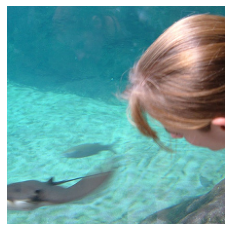

In [6]:
i = 0
label = y_train.argmax(axis=1)[i]
print(f"Label: {label} - {int_to_str[label]}")
x = BGR_to_RGB((X_train + mean_channels).astype(int)[i])

plt.imshow(x);
plt.axis('off');

## Load model

Load a pretrained `tensorflow` model with a ResNet architecture trained on the ImageNet dataset.

In [ ]:
model = ResNet50(weights='imagenet')
preds = model(X_test).numpy().argmax(axis=1)
acc = accuracy_score(y_test.argmax(axis=1), preds)

In [15]:
print('Test accuracy: ', acc)

Test accuracy:  0.86


## Find similar instances

Initializing a `GradientSimilarity` explainer instance.

In [8]:
gsm = GradientSimilarity(model, categorical_crossentropy, precompute_grads=False, sim_fn='grad_cos')

Fitting the explainer on the training data.

In [9]:
gsm.fit(X_train, y_train)

GradientSimilarity(meta={
  'name': 'GradientSimilarity',
  'type': ['whitebox'],
  'explanations': ['local'],
  'params': {
              'sim_fn_name': 'grad_cos',
              'store_grads': False,
              'backend_name': 'tensorflow',
              'task_name': 'classification'}
            ,
  'version': '0.6.6dev'}
)

Selecting 5 random classes out of 10 and 1 random instance per class from the test set (5 test instances in total).

In [10]:
idxs_samples = np.array([np.random.choice(range(5 * i, 5 * i + 5)) for i in range(10)])
idxs_samples = np.random.choice(idxs_samples, 5, replace=False)

X_sample, y_sample = X_test[idxs_samples], y_test[idxs_samples]
preds = model(X_sample).numpy().argmax(axis=1)

Getting the most similar instance for the each of the 5 test samples.

In [11]:
expls = gsm.explain(X_sample, y_sample)

## Visualizations

Building a dictionary for each sample for visualization purposes. 
Each dictionary contains

* The original image `x` (with mean channels added back for visualization).
* The corresponding label `y`.
* The corresponding model's prediction `pred`.
* The reference instances ordered by similarity `X_sim` (with mean channels added back for visualization).
* The corresponding reference labels ordered by similarity `y_sim`.
* The corresponding model's predictions for the reference set `preds_sim`.

In [ ]:
ds = []
for j in range(len(X_sample)):
    y_sim = y_train[expls.data['ordered_indices'][j]].argmax(axis=1)
    X_sim = X_train[expls.data['ordered_indices'][j]]
    preds_sim = model(X_sim).numpy().argmax(axis=1)

    d = {'x': (X_sample + mean_channels).astype(int)[j], 
         'y': y_sample[j].argmax(), 
         'pred':preds[j],
         'X_sim': (X_sim + mean_channels).astype(int),
         'y_sim': y_sim, 
         'preds_sim': preds_sim}
    ds.append(d)

### Most similar instances

Showing the 5 most similar instances for each of the test instances, ordered from the most similar to the least similar.

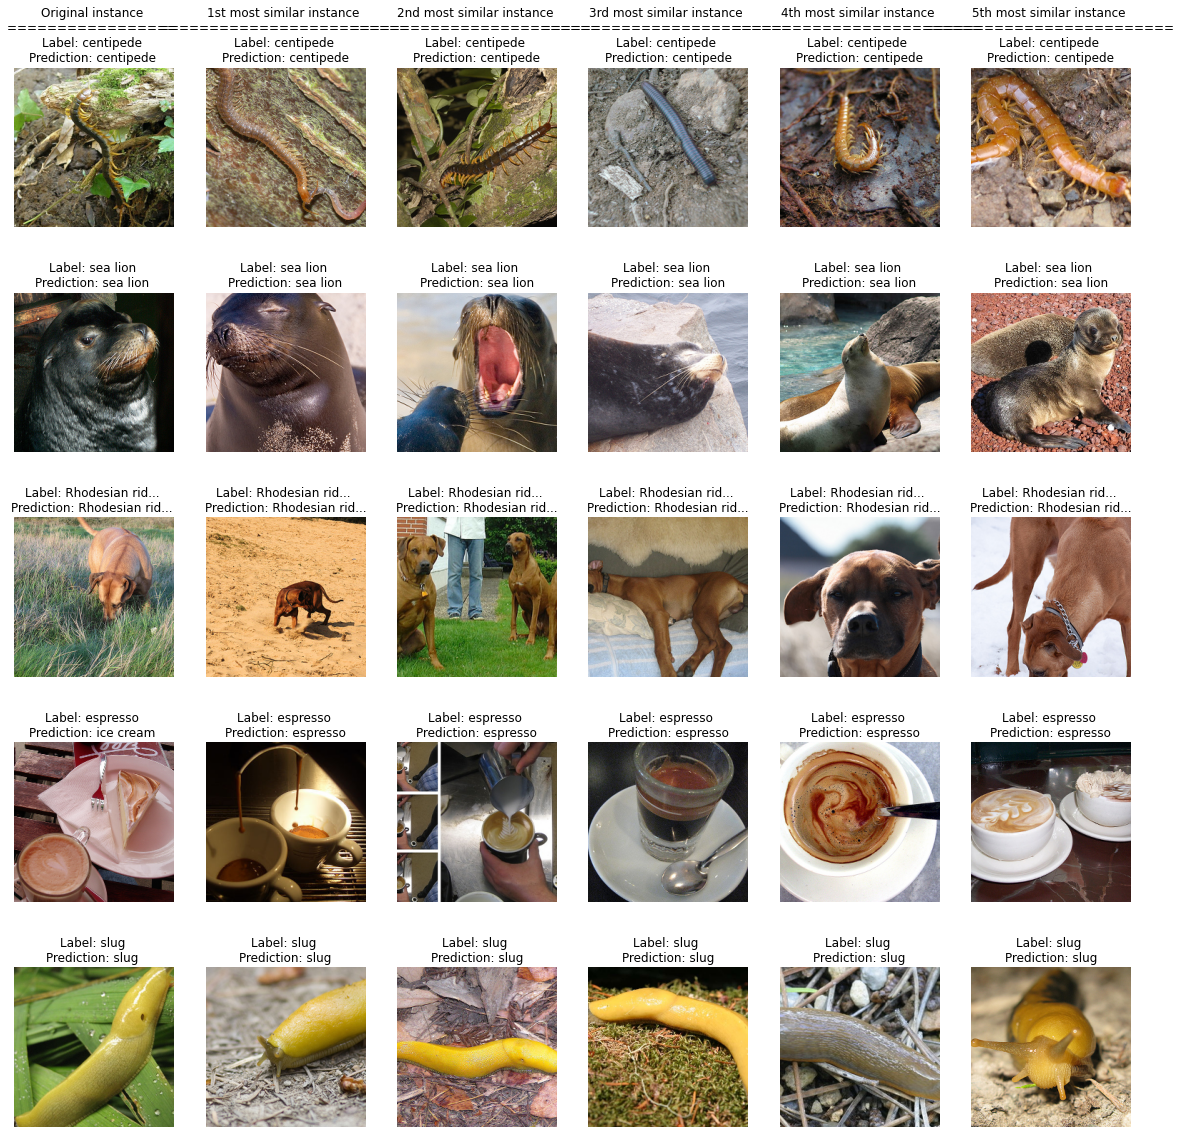

In [13]:
plot_similar(ds, expls, int_to_str, mean_channels)

### Most similar labels distributions 

Showing the average similarity scores for each group of instances in the reference set belonging to the same true class. It can be seen that the higher score corresponds to the class of the original instance, as expected.

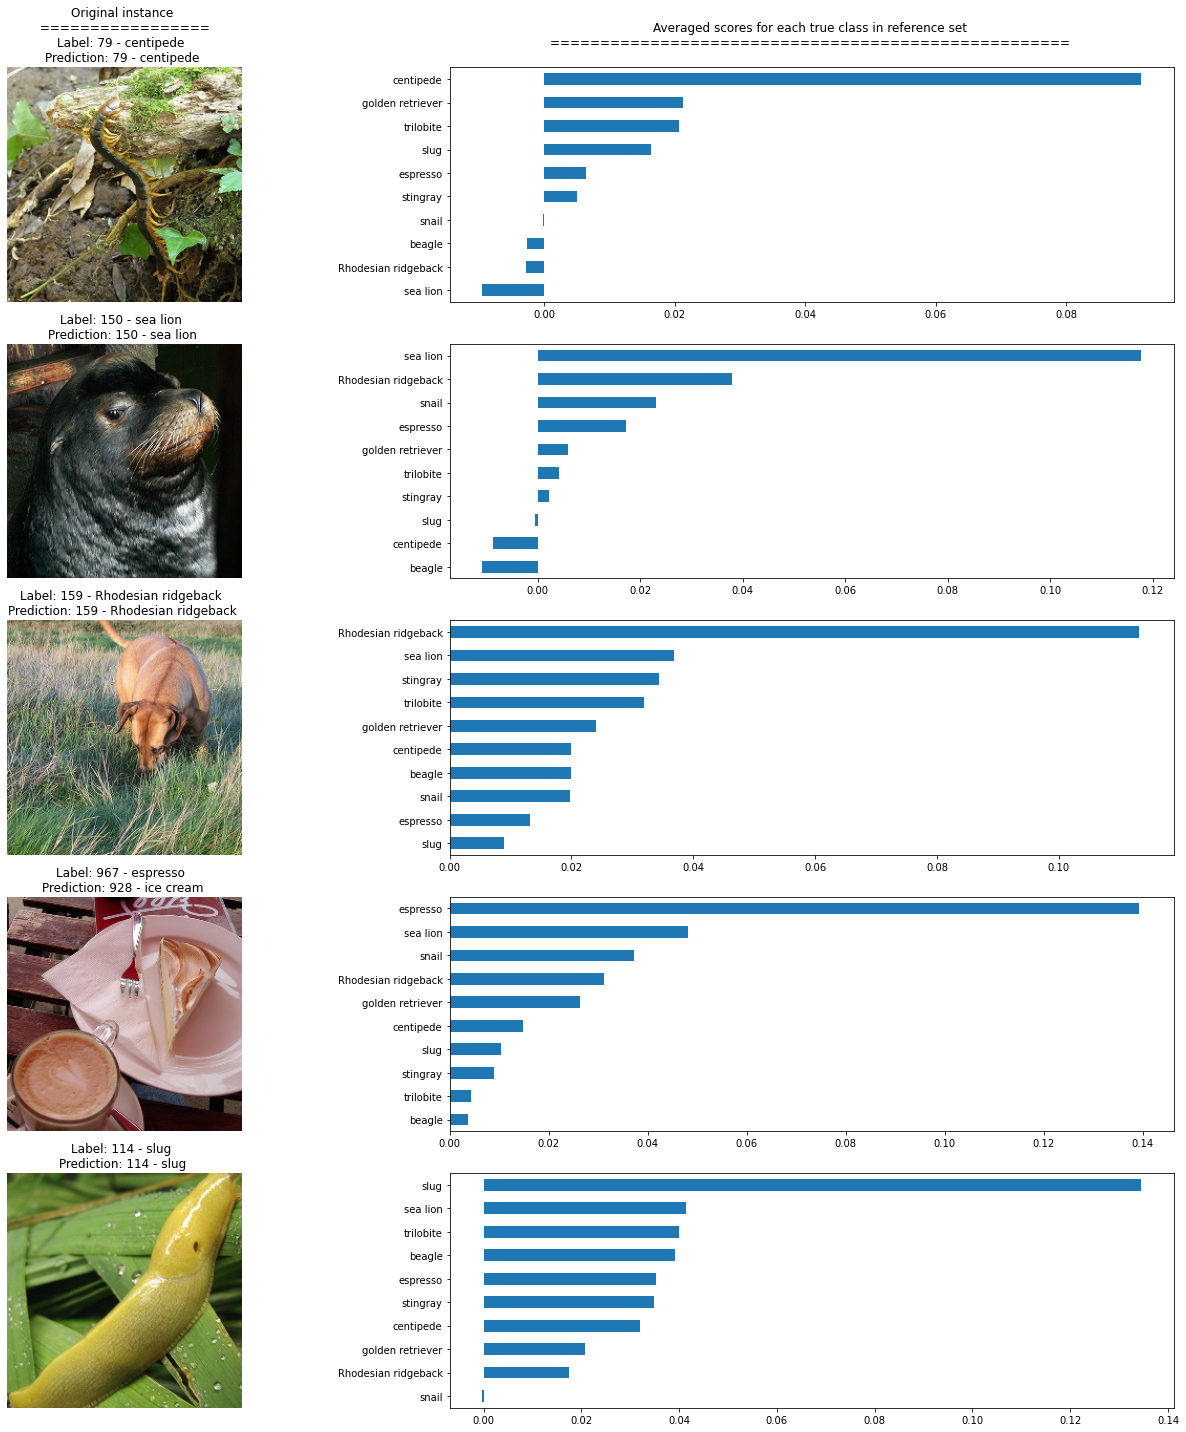

In [14]:
plot_distributions(ds, expls, int_to_str)